## Food Classifiction

In [2]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Creating data loaders

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

### Model creation

Using transfer learning to leverage extensively trained models from tensorflow hub

In [23]:
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [24]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [25]:
import tf_keras
def create_model(model_url, num_classes):
    # Grabbing a pre-trained layer from tensorflow hub
    feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, input_shape=IMAGE_SHAPE+ (3,), name='feature_extraction_layer')
    
    model = tf_keras.Sequential()
    model.add(feature_extractor_layer)
    model.add(tf_keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax, name='output_layer'))
    
    return model 

Creating a ResNet model

In [26]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [27]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [28]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 15s 524ms/step - loss: 1.9578 - accuracy: 0.3440 - val_loss: 1.1859 - val_accuracy: 0.6496
Epoch 2/5
24/24 [==============================] - 11s 495ms/step - loss: 0.8809 - accuracy: 0.7493 - val_loss: 0.8467 - val_accuracy: 0.7316
Epoch 3/5
24/24 [==============================] - 12s 499ms/step - loss: 0.6012 - accuracy: 0.8413 - val_loss: 0.7510 - val_accuracy: 0.7552
Epoch 4/5
24/24 [==============================] - 12s 503ms/step - loss: 0.4668 - accuracy: 0.8827 - val_loss: 0.6958 - val_accuracy: 0.7608
Epoch 5/5
24/24 [==============================] - 12s 496ms/step - loss: 0.3661 - accuracy: 0.9200 - val_loss: 0.6660 - val_accuracy: 0.7844


Plotting loss curves for ResNet model

In [29]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
     

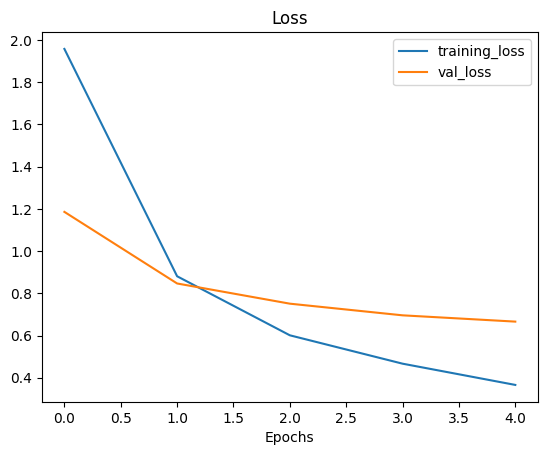

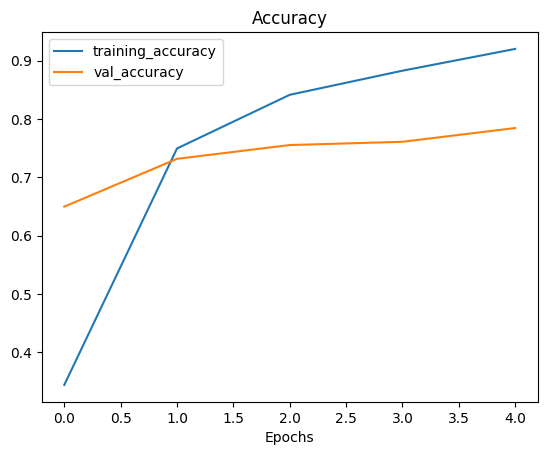

In [30]:
plot_loss_curves(resnet_history)

> Result Summary: The results are good but not greate since the 2 lines in both the graphs do not go together (Gradients are increasing/decreasing at the same rate). 

### Creating a model with EfficientNet80 feature extraction model

In [31]:
effnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)
effnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
effnet_history = effnet_model.fit(train_data_10_percent, 
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 16s 441ms/step - loss: 1.8585 - accuracy: 0.4013 - val_loss: 1.3186 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 8s 352ms/step - loss: 1.0734 - accuracy: 0.7667 - val_loss: 0.8839 - val_accuracy: 0.8036
Epoch 3/5
24/24 [==============================] - 8s 346ms/step - loss: 0.7854 - accuracy: 0.8280 - val_loss: 0.7022 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 8s 354ms/step - loss: 0.6181 - accuracy: 0.8653 - val_loss: 0.6244 - val_accuracy: 0.8444
Epoch 5/5
24/24 [==============================] - 8s 333ms/step - loss: 0.5301 - accuracy: 0.8800 - val_loss: 0.5701 - val_accuracy: 0.8560


Plotting loss curves for the model

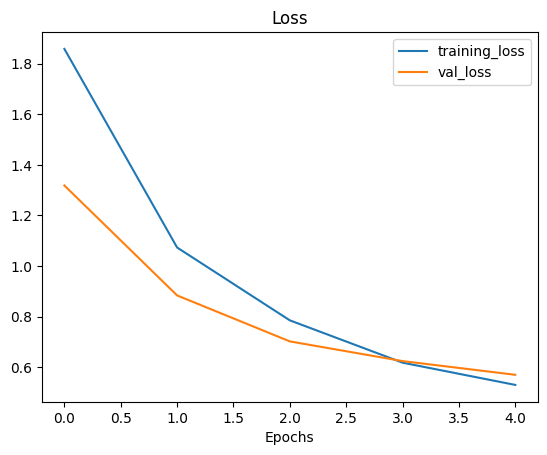

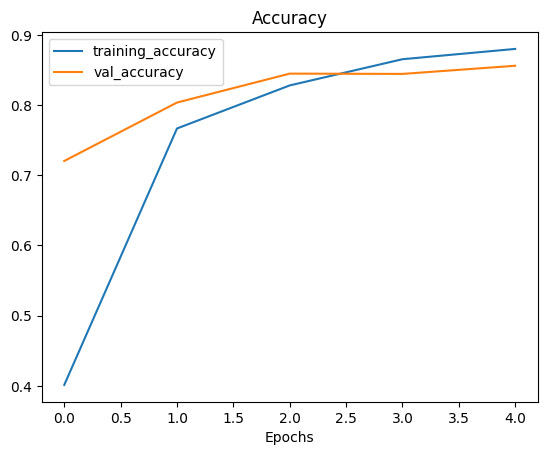

In [32]:
plot_loss_curves(effnet_history)

> Results Summary: The model has given better results! The lines in both graphs are almost meeting each other which is a sign of a well trained model.

### Making predictions with the models

In [33]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [44]:
class_names = ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger',
 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']

In [35]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

In [46]:
def pred_and_plot(model, filename, class_names):
    img = load_and_prep_image(filename)

    pred = model.predict(tf.expand_dims(img, axis=0))

    if len(pred[0]) > 1:
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

1/1 [==============================] - 0s 49ms/step


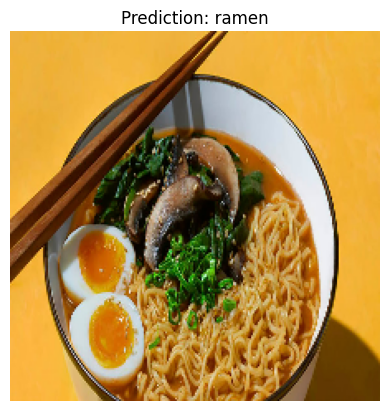

In [58]:
pred_and_plot(effnet_model, "ramen.jpg", class_names)

In [59]:
effnet_model.save('food_pred.h5')

/Users/arjunvarma/Desktop/Programs/Python/Artificial Intelligence/Tensorflow/CNN-Project/Food-Classifier-CNN/venv-metal/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
